In [1]:
import requests
from PIL import Image
import io
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import pandas as pd
import numpy as np
import webbrowser

In [2]:
#local server api
URL = 'http://localhost:5000/'

## Clickable images

fontions used for the clickable image proto

In [3]:
# image callback

def onMouse(event, x, y, flags, links):
    """
    When mouse inside, display clickable area in image
    Open link in web browser when image clicked
    
    input : 
        x,y : position of the mouse on the image 
        links : Links object. Allows  to make the image interactive
    
    

    """
    
    if event == cv2.EVENT_LBUTTONDOWN:
        # Open the link in the web browser
        links.itemClicked(x,y) 
        
    if event == cv2.EVENT_MOUSEMOVE: 
        # When inside clothes area, display the border of the area
        links.displayArea(x,y)

In [59]:
class Links:
    """
    Class that makes images clickable
    """
    
    
    def __init__(self, data, items, path):
        """
        data : bbox of all predicted clothes
        items : links associated with clothes
        img : image 
        path : path of the image
        colors : bbox colors
        thickness : bbox border thickness
        display : bool to display area'border only when mouse inside
        
        """
        self.data = data
        self.items = items
        self.display = False
        self.img = cv2.imread(path)
        self.path = path
        self.colors = [(255, 137, 22), (67, 240, 67),(142, 25, 76), (78, 180, 243), (165, 134, 245), (92, 9, 50)]
        self.thickness = 2
        self.display = [False for k in range(len(data))] 
            
            

               
    def itemClicked(self,x,y): 
        """
        method who detect which clothes has been clicked, and open the corresponding link
        """
        
        for index in range(self.data.shape[0]): 
            #check for each item if mouse inside the area : if inside open the link
            if( (x > self.data[index,0]) and (x < self.data[index,2])
               and (y > self.data[index,1]) and (y < self.data[index,3])):
    #                 webbrowser.open(items[self.data[frame][6]])
                  webbrowser.open(items[index])
#                   webbrowser.open('https://fr.shein.com/Men-Solid-Notched-Neck-Tee-p-9079332-cat-1978.html?url_from=fradplasm2112064364522856M_GPM&cid=16923873116&setid=&adid=&pf=GOOGLE&gclid=CjwKCAjwwo-WBhAMEiwAV4dybdFPPKeAXk-t6suc5z_-2aqXyCbqWfYIHA3xfRMTYOlTExBxcQFPSxoC8IwQAvD_BwE')
                  break
                
                
    def displayArea(self, x, y):
        """
        method who detect if mouse in clickable area. If inside, display border of this area as  insight for the customer he 
        can click
        """
 

        for index in range(self.data.shape[0]):  
            # check at every move of the mouse if mouse inside or not area
            if( (x > self.data[index,0]) and (x < self.data[index,2])
               and (y > self.data[index,1]) and (y < self.data[index,3])):

                if(not self.display[index]):         
                    # if mouse inside area, display the area

                    self.display[index] = True              
                    cv2.imshow('image',cv2.rectangle(self.img, (int(self.data[index,0]),int(self.data[index,1])),
                              (int(self.data[index,2]),int(self.data[index,3])), self.colors[index],self.thickness))
                    cv2.setMouseCallback('image', onMouse, links)
                    cv2.waitKey(0)
                    
                    

            else : 
                if (self.display[index]):               
                    # if mouse quit area stop displaying the area

                    self.display[index] = False
                    self.img = cv2.imread(self.path)
                    cv2.imshow('image',self.img)
                    cv2.setMouseCallback('image', onMouse, links)
                    cv2.waitKey(0)

        

    
    def getItems(self):
        #get position of clothes 
        
        return (self.data)
       
                
    def clearLinks(self): 
        #clear the onject
        self.data = {}
        self.items = {}
        self.path = " "
        self.img = None
        self.frame_index = 0
        self.display = [False for k in range(len(self.data))] 
        self.color = (255, 0, 0)
        self.thickness = 2
        
    def reset(self): 
        #reset the object
        self.display = [False for k in range(len(self.data))] 

## Test if the server is running

In [48]:
response = requests.get(URL).json()
response

{'msg': 'Get ok'}

In [31]:
response = requests.post(URL,  json={"msg": "test de la méthode post"}).json()
response

{'msg': 'test de la méthode post'}

## Retrieve the list of existing AI models 

In [41]:
response = requests.get(URL + "models").json()
response

{'models': ['Fashion_Datasets_50_labels_V1']}

## Clothing detection and clickable image prototype

In [51]:
image_path = "C:/Users/Montassier Paul/Documents/Bazar/iaAPI/iaAPI/img_test.jpg"
image_data = open(image_path, "rb").read()
response = requests.post(URL + "/object_detection", files={"image": image_data}).json()
response

{'result': '[{"xmin":118.6928024292,"ymin":100.7062988281,"xmax":176.1818084717,"ymax":192.7524108887,"confidence":0.5261660814,"class":16,"name":"Tank"},{"xmin":112.1839294434,"ymin":207.7719116211,"xmax":183.2527160645,"ymax":261.6682739258,"confidence":0.099006474,"class":31,"name":"Shorts"}]'}

In [52]:
#Fit the bbox predicted with the resized image on the server with the true image

img = Image.open(io.BytesIO(image_data))
w, h = img.size
pred = json.loads(response["result"])
for i in range(len(pred)): 
    pred[i]["xmin"] = pred[i]["xmin"] + (w - 300)/2
    pred[i]["xmax"] = pred[i]["xmax"] + (w - 300)/2
    pred[i]["ymin"] = pred[i]["ymin"] + (h - 300)/2
    pred[i]["ymax"] = pred[i]["ymax"] + (h - 300)/2

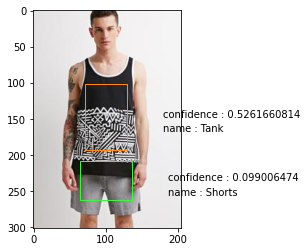

In [54]:
#display results

colors = ['#ff8916', '#43f043','#8e194c', '#4eb4f3', '#a586f5', '#5c0932']
plt.imshow(img)

for i in range(len(pred)):
    plt.gca().add_patch(Rectangle((pred[i]["xmin"],pred[i]["ymin"]),pred[i]["xmax"] - pred[i]["xmin"],
                        pred[i]["ymax"] - pred[i]["ymin"],linewidth=1,edgecolor=colors[i],facecolor='none'))

    plt.text(pred[i]["xmax"] + 50,(pred[i]["ymax"] + pred[i]["ymin"]) / 2,'confidence : ' + str(pred[i]["confidence"]))
    plt.text(pred[i]["xmax"] + 50,(pred[i]["ymax"] + pred[i]["ymin"]) / 2 + 20,'name : ' + str(pred[i]["name"]))

### Proto clickable image

In [60]:
items = [
    "https://fr.shein.com/Men-Solid-Notched-Neck-Tee-p-9079332-cat-1978.html?url_from=fradplasm2112064364522856M_GPM&cid=16923873116&setid=&adid=&pf=GOOGLE&gclid=CjwKCAjwwo-WBhAMEiwAV4dybdFPPKeAXk-t6suc5z_-2aqXyCbqWfYIHA3xfRMTYOlTExBxcQFPSxoC8IwQAvD_BwE"
    ,"https://www.laboutiqueofficielle.com/achat-shorts-jogging/lbo-short-jogging-119-gris-chine-98379.html?referer=gshopping&LGWCODE=3735187068581;160079;7403&gclid=CjwKCAjwiJqWBhBdEiwAtESPaPxsfh0xCxSqZRvJkpdyUzRumkwCvGmcjm6vIOppIE2ddyYdng2ePhoC3uYQAvD_BwE"
]
links = Links(np.array(pd.DataFrame(pd.DataFrame(pred))), {},image_path)

In [61]:
img = cv2.imread(image_path)
cv2.imshow('image',img)
cv2.setMouseCallback('image', onMouse, links)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Get the model confidence level

In [50]:
response = requests.post(URL + "new_conf", json={"conf": "0.05"}).json()
response

{'msg': 'New confidence threshold applied'}

## Change the confidence level of the model 

In [45]:
response = requests.get(URL + "model_conf").json()
response

{'conf': 0.1}

## Get the name of the AI model currently running on the server 

In [36]:
response = requests.get(URL + "model_name").json()
response


{'model_name': 'Fashion_Datasets_50_labels_V1'}

## switch to a different model 

In [37]:
response = requests.post(URL + "switch_model", json={"new_model": "Fashion_Datasets_50_labels_V1"}).json()
response

{'msg': 'le modèle à bien été changé'}